# PCA & Clustering Assignment

#### problem overview

HELP International is an international humanitarian NGO that is committed to fighting poverty and providing the people of backward countries with basic amenities and relief during the time of disasters and natural calamities. It runs a lot of operational projects from time to time along with advocacy drives to raise awareness as well as for funding purposes. After the recent funding programmes, they have been able to raise around $ 10 million. Now the CEO of the NGO needs to decide how to use this money strategically and effectively. The significant issues that come while making this decision are mostly related to choosing the countries that are in the direst need of aid. 
 
Idea is to categorise the countries using some socio-economic and health factors that determine the overall development of the country. Then we can suggest the countries which the CEO needs to focus on the most.

The steps are broadly:

1. Read and understand the data.
2. Clean and outlier analysis.
3. Data transformation and standardization for PCA.
4. PCA application on data.
5. K-means clustering with principal components
6. Hierachical clustering
5. Final analysis and reccomendations.

In [520]:
# Import required libraries.

import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Scaling.
from sklearn.preprocessing import scale

# K Means clustering 
from sklearn.cluster import KMeans

# Hierarchical clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

## Step 1: Reading and Understanding the Data


In [521]:
# import data.

df = pd.read_csv("Country-data.csv")
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [522]:
# Explore shape of data frame - rows and 26 columns.
df.shape

(167, 10)

In [523]:
# Explore info of Data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null int64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 13.1+ KB


In [524]:
# Summary Statistics for each column.
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [525]:
# Observe the features(columns) and analyse which can be dropped at later point.
df.columns

Index(['country', 'child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp'],
      dtype='object')

## Step 2 : Data cleaning and Transformation.


1. The methods ```isnull()``` and ```notnull()``` are the most common ways of identifying missing values.
2. Data must to transformed to required values before applying PCA.

In [526]:
# summing up the missing values (column-wise)
df.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

 We can proceed with data transformation and visualization since no missing values.

In [527]:
# Convert the required columns.

df['exports'] = df['exports'] * df['gdpp']/100
df['imports'] = df['imports'] * df['gdpp']/100
df['health']  = df['health']  * df['gdpp']/100

df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


## Step 3 : Visualising the Data

We'll visualise our data using `matplotlib` and `seaborn`.

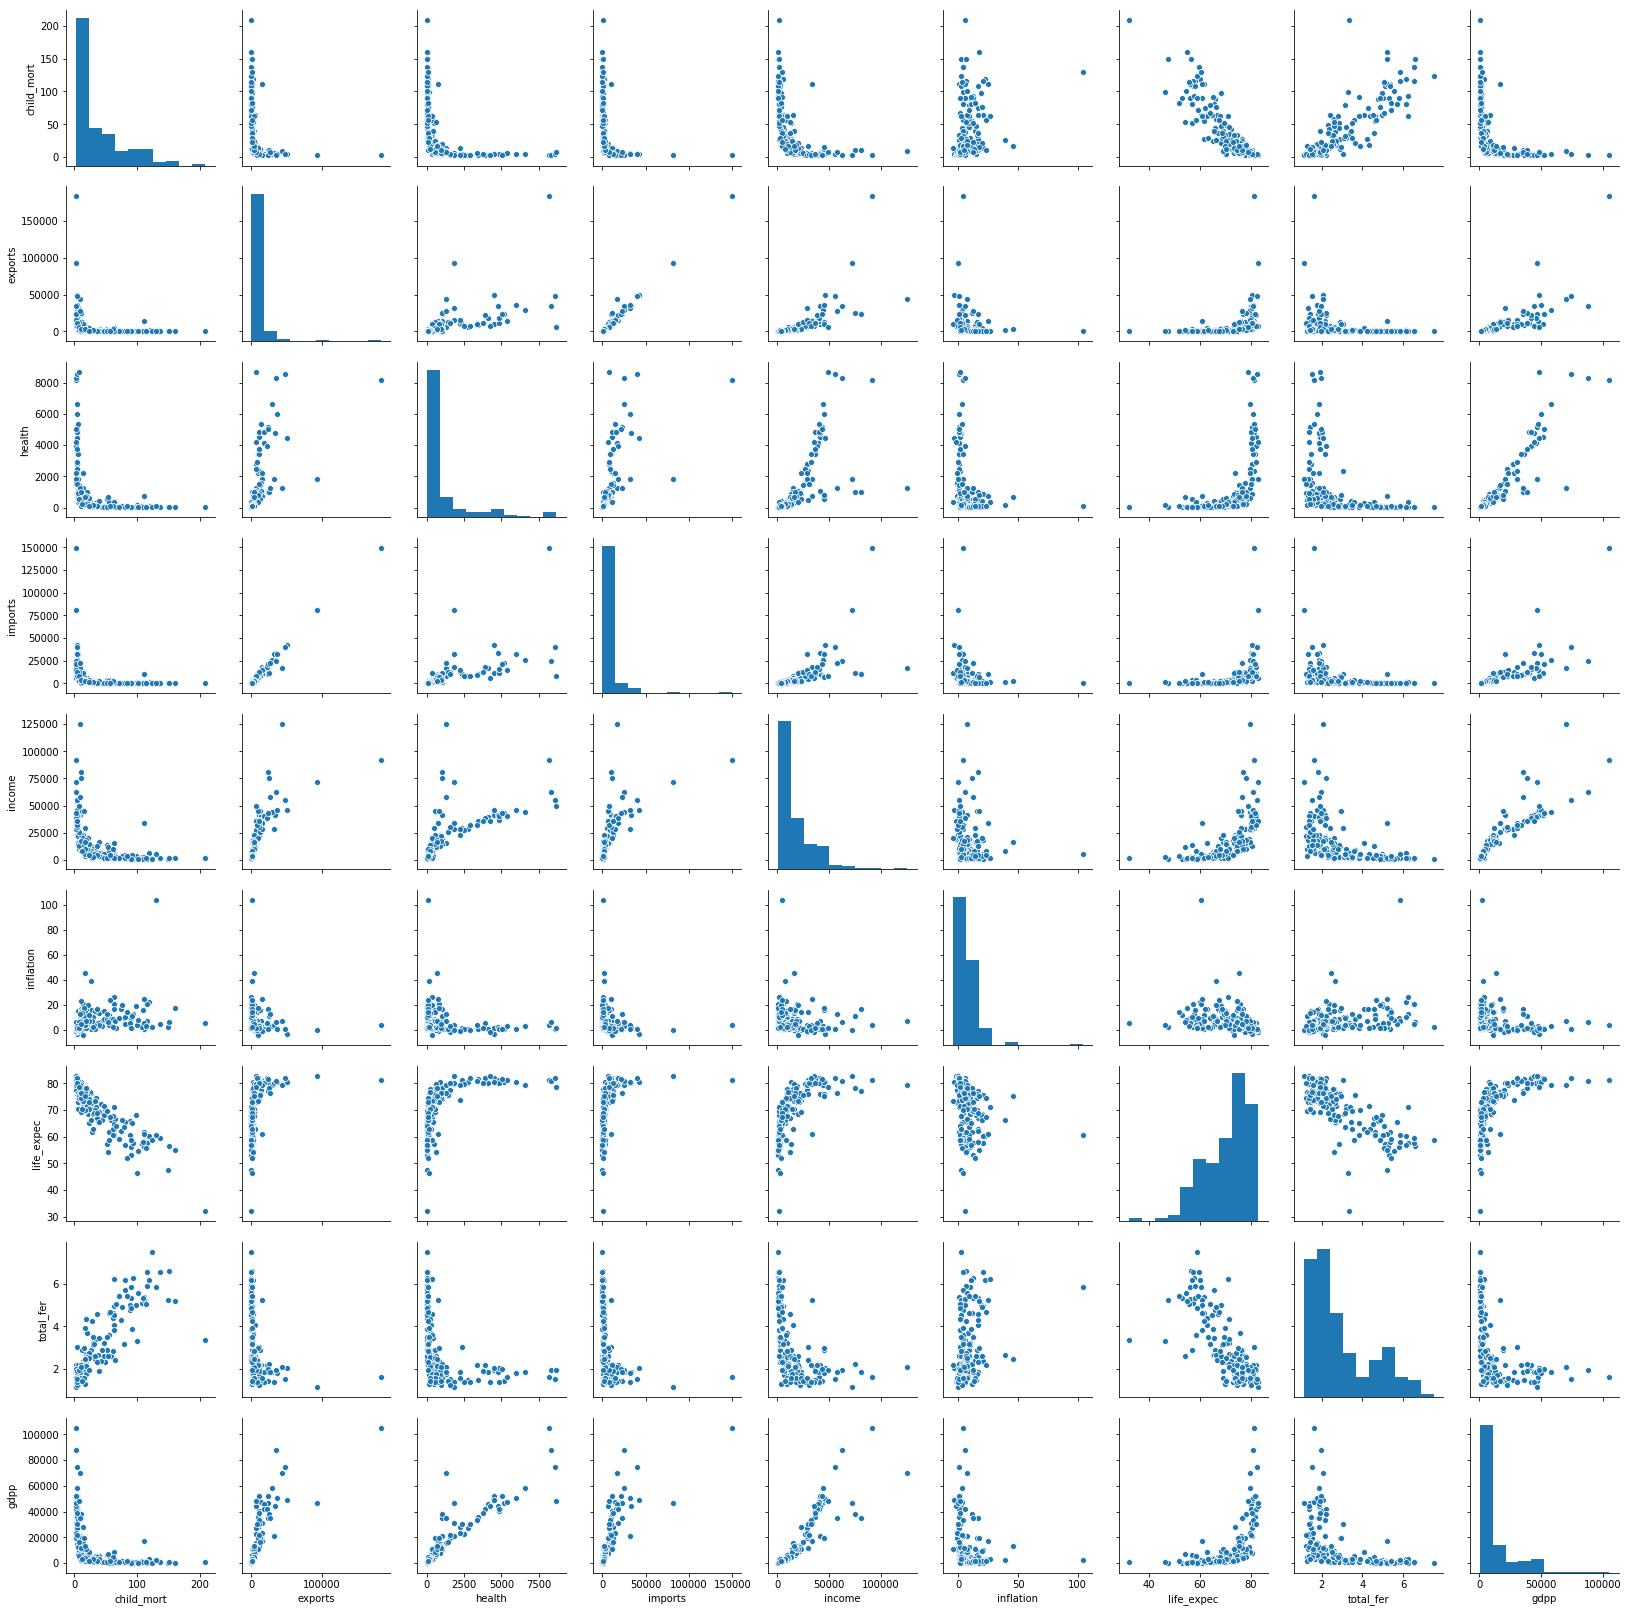

In [528]:
sns.pairplot(df)
plt.show()

## Step 4 : Principal Component Analysis

In [529]:
## Standardize the data.
df_scaled = df.copy()

num_cols = df.columns[df.dtypes.apply(lambda c: np.issubdtype(c, np.number))]

from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
df_scaled[num_cols] = standard_scaler.fit_transform(df_scaled[num_cols])
df_scaled.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,1.291532,-0.411011,-0.565040,-0.432276,-0.808245,0.157336,-1.619092,1.902882,-0.679180
1,Albania,-0.538949,-0.350191,-0.439218,-0.313677,-0.375369,-0.312347,0.647866,-0.859973,-0.485623
2,Algeria,-0.272833,-0.318526,-0.484826,-0.353720,-0.220844,0.789274,0.670423,-0.038404,-0.465376
3,Angola,2.007808,-0.291375,-0.532363,-0.345953,-0.585043,1.387054,-1.179234,2.128151,-0.516268
4,Antigua and Barbuda,-0.695634,-0.104331,-0.178771,0.040735,0.101732,-0.601749,0.704258,-0.541946,-0.041817


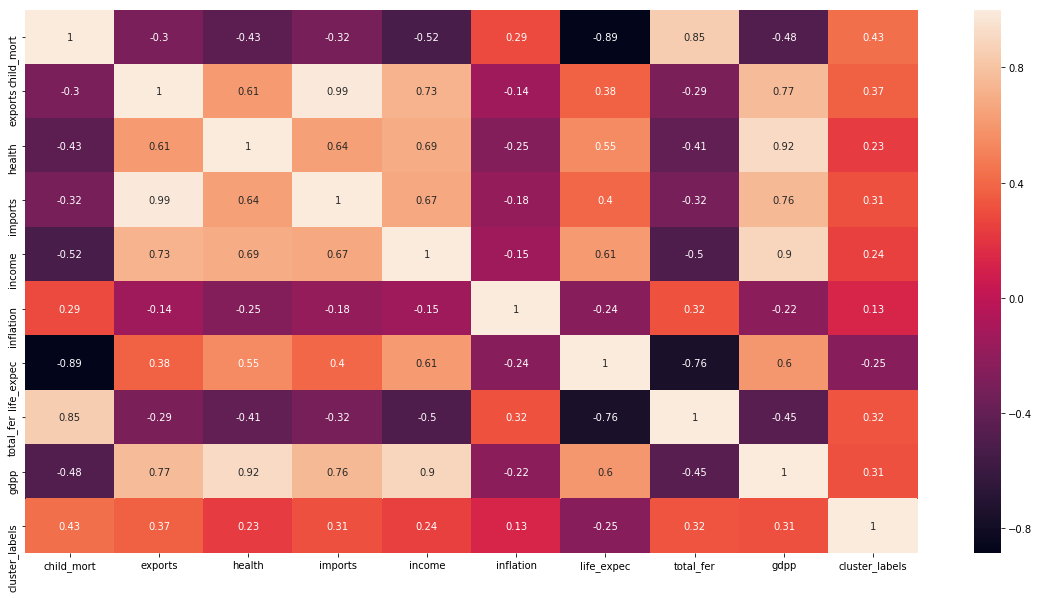

In [585]:
# Let's see the correlation matrix 

plt.figure(figsize = (20,10))        # Size of the figure
sns.heatmap(df.corr(),annot = True)

In [531]:
#Importing the PCA module
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized', random_state=42)

In [532]:
#Performing the PCA
pca.fit(df_scaled[num_cols])

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
  svd_solver='randomized', tol=0.0, whiten=False)

In [533]:
#List of PCA components.
pca.components_

array([[-0.31639186,  0.34288671,  0.358535  ,  0.34486492,  0.38004113,
        -0.14308531,  0.34385651, -0.30284224,  0.39998795],
       [ 0.47626735,  0.39731091,  0.1550529 ,  0.37078075,  0.12838448,
         0.22126089, -0.36981973,  0.4597152 ,  0.2006241 ],
       [-0.15001225, -0.03057367, -0.07570322, -0.07217386,  0.14576421,
         0.94841868,  0.19675173, -0.07783431,  0.01033941],
       [-0.14805195,  0.44942527, -0.59971228,  0.46179779, -0.15480592,
        -0.00762798, -0.01839465, -0.21392805, -0.36477239],
       [ 0.1019948 , -0.03853829, -0.49319984, -0.2527867 ,  0.79407469,
        -0.13642345, -0.15404105, -0.02033568,  0.08750149],
       [ 0.19658519, -0.03891112,  0.18069888, -0.01217988, -0.03814681,
         0.10840284, -0.58600986, -0.75390075,  0.04538167],
       [ 0.76126725, -0.01366973, -0.06461567,  0.02718244, -0.02311312,
        -0.02207663,  0.58120846, -0.27314534, -0.04402264],
       [ 0.00644411, -0.05526371,  0.43007213,  0.1311355 ,  0

In [534]:
#Let's check the variance ratios
pca.explained_variance_ratio_

array([5.89372984e-01, 1.84451685e-01, 9.91147170e-02, 6.07227801e-02,
       3.02917253e-02, 2.45982702e-02, 9.39743701e-03, 1.55641971e-03,
       4.93981394e-04])

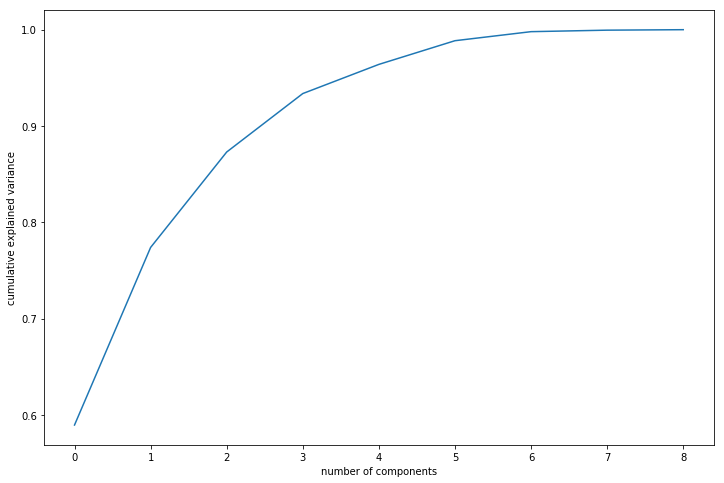

In [535]:
#Plotting the scree plot
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

Around 94% of the information is being explained by 3 components and around 88% of variance explained by 2 principal componenets, so we shall proceed our analysis with 2 components.

In [536]:
#Understanding how the original variables are loaded on the principal components. It can be verified from above as well.
pcs_df = pd.DataFrame({ 'Feature':num_cols,'PC1':pca.components_[0],'PC2':pca.components_[1]})
pcs_df

,Feature,PC1,PC2
0,child_mort,-0.316392,0.476267
1,exports,0.342887,0.397311
2,health,0.358535,0.155053
3,imports,0.344865,0.370781
4,income,0.380041,0.128384
5,inflation,-0.143085,0.221261
6,life_expec,0.343857,-0.369820
7,total_fer,-0.302842,0.459715
8,gdpp,0.399988,0.200624


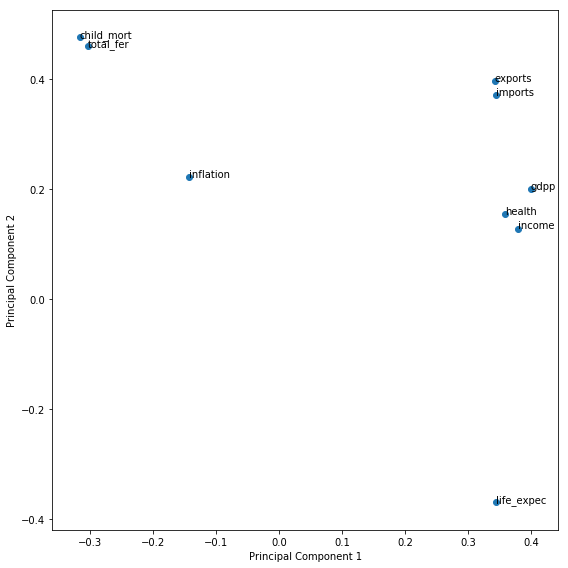

In [537]:
# Let's plot them to visualise how these features are loaded
%matplotlib inline
fig = plt.figure(figsize = (8,8))
plt.scatter(pcs_df.PC1, pcs_df.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(pcs_df.Feature):
    plt.annotate(txt, (pcs_df.PC1[i],pcs_df.PC2[i]))
plt.tight_layout()
plt.show()

In [538]:
#Finally let's go ahead and do dimenstionality reduction using two Principal Components
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=2)

In [539]:
df_pca = pca_final.fit_transform(df_scaled[num_cols])
df_pca.shape

(167, 2)

In [540]:
df_pca

array([[-2.63781321e+00,  1.48536461e+00],
       [-2.28210939e-02, -1.42971156e+00],
       [-4.56234772e-01, -7.07360261e-01],
       [-2.72276377e+00,  2.15229306e+00],
       [ 6.49117451e-01, -1.01774207e+00],
       [ 3.94157308e-02, -7.30261748e-01],
       [-3.32874986e-01, -1.27774541e+00],
       [ 3.18004346e+00, -2.42945480e-01],
       [ 3.81521984e+00,  2.70503210e-01],
       [-4.66682132e-01, -5.12070612e-01],
       [ 1.49764135e+00, -4.07261928e-01],
       [ 1.47173856e+00, -3.48835344e-01],
       [-1.01470326e+00, -7.04204726e-01],
       [ 8.44156324e-01, -9.92326449e-01],
       [-1.23125395e-02, -1.01063660e+00],
       [ 3.96056409e+00,  8.51654535e-01],
       [-4.03848235e-01, -9.05487852e-01],
       [-2.36763892e+00,  1.20900783e+00],
       [-7.15518871e-01, -7.61656090e-01],
       [-1.01785700e+00, -4.27509939e-01],
       [ 2.51782613e-01, -1.68612275e+00],
       [-1.13121768e+00,  4.07034302e-01],
       [ 1.66361284e-01, -1.02506573e+00],
       [ 2.

In [541]:
#Creating a transpose so that the each column is properly arranged
pc = np.transpose(df_pca)

In [542]:
pcs_df2 = pd.DataFrame({'PC1':pc[0],'PC2':pc[1]})
pcs_df2.head()

,PC1,PC2
0,-2.637813,1.485365
1,-0.022821,-1.429712
2,-0.456235,-0.707360
3,-2.722764,2.152293
4,0.649117,-1.017742


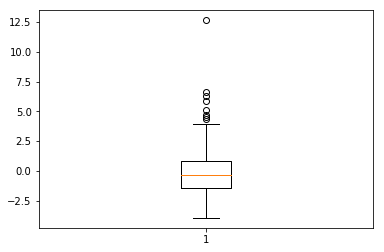

In [543]:
## Let's perform Outlier Analysis
#Let's do the outlier analysis before proceeding to clustering

plt.boxplot(pcs_df2.PC1)

Q1 = pcs_df2.PC1.quantile(0.05)
Q3 = pcs_df2.PC1.quantile(0.95)
IQR = Q3 - Q1
pcs_df2 = pcs_df2[(pcs_df2.PC1 >= Q1) & (pcs_df2.PC1 <= Q3)]

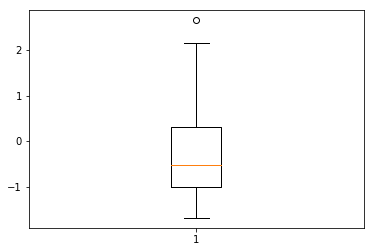

In [544]:
# Outlier for PC2.

plt.boxplot(pcs_df2.PC2)

Q1 = pcs_df2.PC2.quantile(0.05)
Q3 = pcs_df2.PC2.quantile(0.95)
IQR = Q3 - Q1
pcs_df2 = pcs_df2[(pcs_df2.PC2 >= Q1) & (pcs_df2.PC2 <= Q3)]

In [545]:
pcs_df2.shape

(133, 2)

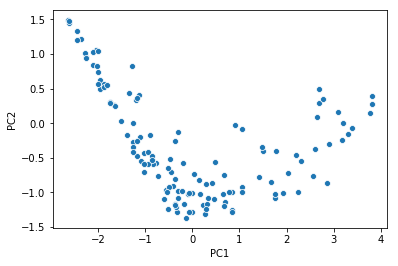

In [546]:
#Visualising the points on the PCs.
# one of the prime advatanges of PCA is that you can visualise high dimensional data
sns.scatterplot(x='PC1',y='PC2',data=pcs_df2)

## Step 5 : K- means Clustering

In [547]:
#Calculating the Hopkins statistic
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [548]:
#Let's check the Hopkins measure
hopkins(pcs_df2)

0.7878313570697429

In [549]:
#Since the value is > 0.5 the given dataset has a good tendency to form clusters.

dat3_1 = pcs_df2

In [550]:
#First we'll do the silhouette score analysis
from sklearn.metrics import silhouette_score
sse_ = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k).fit(dat3_1)
    sse_.append([k, silhouette_score(dat3_1, kmeans.labels_)])

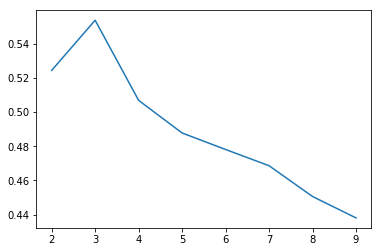

In [551]:
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1]);

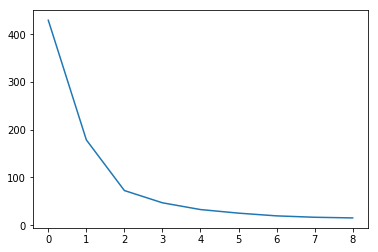

In [552]:
#Now let's proceed to the elbow curve method
ssd = []
for num_clusters in list(range(1,10)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(dat3_1)
    ssd.append(model_clus.inertia_)

plt.plot(ssd)

### From the above analysis we find that 2 seems to be a good number of clusters for K means algorithm


In [553]:
#Here also we're seeing a distinct bend at around 2 clusters. Hence it seems a good K to choose.
#Let's perform K means using K=2
model_clus2 = KMeans(n_clusters = 2, max_iter=50,random_state = 50)
model_clus2.fit(dat3_1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=50, tol=0.0001, verbose=0)

In [554]:
dat4 = pcs_df2
dat4.index = pd.RangeIndex(len(dat4.index))
dat_km = pd.concat([dat4, pd.Series(model_clus2.labels_)], axis=1)
dat_km.columns = ['PC1', 'PC2','ClusterID']
dat_km.head()

,PC1,PC2,ClusterID
0,-2.637813,1.485365,0
1,-0.456235,-0.707360,0
2,0.649117,-1.017742,1
3,0.039416,-0.730262,0
4,-0.332875,-1.277745,0


In [555]:
dat_km['ClusterID'].value_counts()

0    93
1    40
Name: ClusterID, dtype: int64

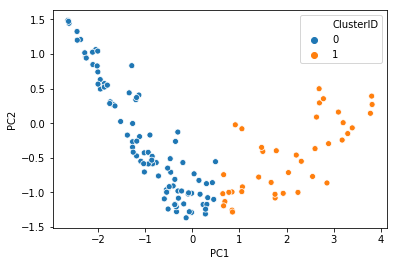

In [556]:
sns.scatterplot(x='PC1',y='PC2',hue='ClusterID',legend='full',data=dat_km)

In [557]:
dat5 = pd.merge(df,dat_km, left_index=True,right_index=True)
dat5.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,PC1,PC2,ClusterID
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553,-2.637813,1.485365,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090,-0.456235,-0.707360,0
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460,0.649117,-1.017742,1
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530,0.039416,-0.730262,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200,-0.332875,-1.277745,0


In [558]:
dat6=dat5.drop(['PC1','PC2'],axis=1)
dat6.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,ClusterID
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090,0
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460,1
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200,0


## Analysis of the clusters

Analyse the clusters by comparing how these three variables - [gdpp, child_mort and income] vary for each cluster of countries to recognise and differentiate the clusters of developed countries from the clusters of under-developed countries

In [559]:
cluster_df = dat6[['country', 'child_mort', 'income', 'gdpp', 'ClusterID']]
cluster_df.head()

,country,child_mort,income,gdpp,ClusterID
0,Afghanistan,90.2,1610,553,0
1,Albania,16.6,9930,4090,0
2,Algeria,27.3,12900,4460,1
3,Angola,119.0,5900,3530,0
4,Antigua and Barbuda,10.3,19100,12200,0


In [560]:
# Extract and anlyze means for analysis.

clu_gdpp       = pd.DataFrame(cluster_df.groupby(["ClusterID"]).gdpp.mean())
clu_child_mort = pd.DataFrame(cluster_df.groupby(["ClusterID"]).child_mort.mean())
clu_income     = pd.DataFrame(cluster_df.groupby(["ClusterID"]).income.mean())

In [561]:
df_temp = pd.concat([pd.Series([0,1]),clu_gdpp,clu_child_mort,clu_income], axis=1)

In [562]:
df_temp.columns = ["ClusterID","clu_gdpp","clu_child_mort","clu_income"]
df_temp

,ClusterID,clu_gdpp,clu_child_mort,clu_income
0,0,13606.709677,36.916129,17819.301075
1,1,10324.175000,48.432500,14978.950000


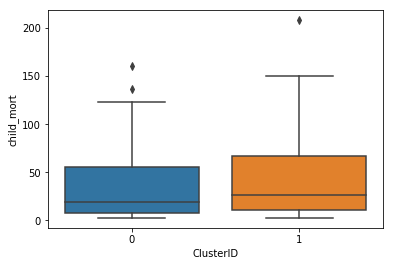

In [563]:
# plot
sns.boxplot(x='ClusterID', y='child_mort', data=dat6)

### Observations:

From the above visualization, we can observe that countries in cluster-0 has lower child_mort rate than cluster-1.

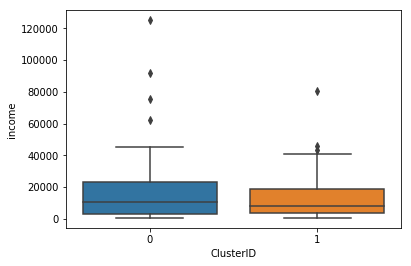

In [564]:
# plot
sns.boxplot(x='ClusterID', y='income', data=dat6)

### Observations:

From the above visualization, we can observe that countries in cluster-0 has higher child mort rate than cluster-1.

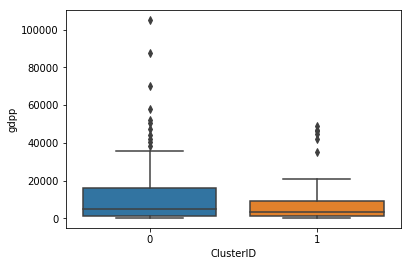

In [565]:
# plot
sns.boxplot(x='ClusterID', y='gdpp', data=dat6)

In [566]:
# Apply binning te get countries for variables 'child_mort', 'income', 'gdpp'.

df_temp.columns = ["ClusterID","clu_gdpp","clu_child_mort","clu_income"]
df_temp

,ClusterID,clu_gdpp,clu_child_mort,clu_income
0,0,13606.709677,36.916129,17819.301075
1,1,10324.175000,48.432500,14978.950000


## Observations - Cluster performances for K-means.

We can derive some insights from the above box plots and average cluster values for Chils_mort, income and GDPP.

1. Cluster 0 has better GDPP and income compared to Cluster  1.
2. Cluster 0 has lower Child mort compared to Cluster  1.
3. Above box plot visualizations depict the same behaiour.

From the above facts we can conclude that cluster - 1 is worst performing and can extract countries performing less than mean values of corresponding mean values for **GDPP = "10324.175", Child-mort = 48.43 and income = 14978.95**.

So finally we will list down the countries having "GDPP","Child-mort","income" values less than above mean values.

In [567]:
#Let's use the concept of binning.

tmp_df = df.loc[  (df['gdpp']       <= 10324.175) 
                & (df['child_mort'] >= 48.43 )
                & (df['income']     <= 14978.95)]
tmp_df

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30000,41.9174,248.297000,1610,9.440,56.2,5.82,553
3,Angola,119.0,2199.19000,100.6050,1514.370000,5900,22.400,60.1,6.16,3530
12,Bangladesh,49.4,121.28000,26.6816,165.244000,2440,7.140,70.4,2.33,758
17,Benin,111.0,180.40400,31.0780,281.976000,1820,0.885,61.8,5.36,758
21,Botswana,52.5,2768.60000,527.0500,3257.550000,13300,8.920,57.1,2.88,6350
25,Burkina Faso,116.0,110.40000,38.7550,170.200000,1430,6.810,57.9,5.87,575
26,Burundi,93.6,20.60520,26.7960,90.552000,764,12.300,57.7,6.26,231
28,Cameroon,108.0,290.82000,67.2030,353.700000,2660,1.910,57.3,5.11,1310
31,Central African Republic,149.0,52.62800,17.7508,118.190000,888,2.010,47.5,5.21,446
32,Chad,150.0,330.09600,40.6341,390.195000,1930,6.390,56.5,6.59,897


In [568]:
# sort values as required to get top 5 countries.
# We shall sort - gdpp in descending so that low gdpp countries can be given more preferences.

final_df = tmp_df.sort_values('gdpp', ascending=True)
final_df

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
26,Burundi,93.6,20.60520,26.7960,90.552000,764,12.300,57.7,6.26,231
88,Liberia,89.3,62.45700,38.5860,302.802000,700,5.470,60.8,5.02,327
37,"Congo, Dem. Rep.",116.0,137.27400,26.4194,165.664000,609,20.800,57.5,6.54,334
112,Niger,123.0,77.25600,17.9568,170.868000,814,2.550,58.8,7.49,348
132,Sierra Leone,160.0,67.03200,52.2690,137.655000,1220,17.200,55.0,5.20,399
93,Madagascar,62.2,103.25000,15.5701,177.590000,1390,8.790,60.8,4.60,413
106,Mozambique,101.0,131.98500,21.8299,193.578000,918,7.640,54.5,5.56,419
31,Central African Republic,149.0,52.62800,17.7508,118.190000,888,2.010,47.5,5.21,446
94,Malawi,90.5,104.65200,30.2481,160.191000,1030,12.100,53.1,5.31,459
50,Eritrea,55.2,23.08780,12.8212,112.306000,1420,11.600,61.7,4.61,482


In [569]:
# extract only 3 variables - cild_mort, income and GDPP.
final_df = final_df[['country', 'child_mort','income','gdpp']]
final_df.head(5)

# Top 5 countries.

# 1. Burundi
# 2. Liberia
# 3. Congo, Dem. Rep.
# 4. Niger
# 5. Sierra Leone

,country,child_mort,income,gdpp
26,Burundi,93.6,764,231
88,Liberia,89.3,700,327
37,"Congo, Dem. Rep.",116.0,609,334
112,Niger,123.0,814,348
132,Sierra Leone,160.0,1220,399


### K-Means clustering conclusions.

From the above Data and visualizations we can conclude that below countries are in dire need of aid.

    # 1. Burundi
    # 2. Liberia
    # 3. Congo, Dem. Rep.
    # 4. Niger
    # 5. Sierra Leone

# Hierarchical Clustering

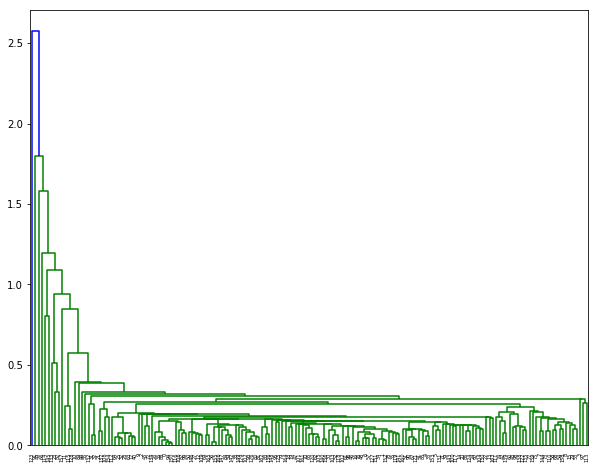

In [570]:
# single linkage
fig = plt.figure(figsize = (10,8))

mergings = linkage(df_scaled[['child_mort', 'income', 'gdpp']], method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

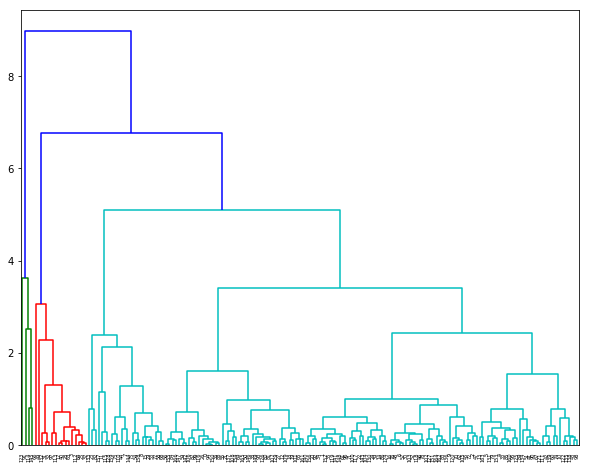

In [571]:
# complete linkage
fig = plt.figure(figsize = (10,8))

mergings = linkage(df_scaled[['child_mort', 'income', 'gdpp']], method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [572]:
# 3 clusters

cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [573]:
# assign cluster labels
df['cluster_labels'] = cluster_labels
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_labels
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090,0
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460,0
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530,1
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200,0


In [574]:
df['cluster_labels'].value_counts()

0    147
1     16
2      4
Name: cluster_labels, dtype: int64

In [575]:
# Extract and anlyze means for analysis.

clu_gdpp       = pd.DataFrame(df.groupby(["cluster_labels"]).gdpp.mean())
clu_child_mort = pd.DataFrame(df.groupby(["cluster_labels"]).child_mort.mean())
clu_income     = pd.DataFrame(df.groupby(["cluster_labels"]).income.mean())

In [576]:
df_temp = pd.concat([pd.Series([0,1,2]),clu_gdpp,clu_child_mort,clu_income], axis=1)
df_temp.columns = ["cluster_labels","clu_gdpp","clu_child_mort","clu_income"]

In [577]:
df_temp.set_index('cluster_labels', inplace=True)
df_temp

,clu_gdpp,clu_child_mort,clu_income
cluster_labels,,,
0,12214.29932,29.24898,16761.238095
1,1988.25000,129.50000,4047.562500
2,84425.00000,4.87500,83625.000000


## Observations - Cluster performances for Hierarchical clustering.

We can derive some insights from the mean cluster values for Chils_mort, income and GDPP.

1. Cluster 0 and 2 has better GDPP and income compared to Cluster  1.
2. Cluster 0 and 2 has lower Child mort compared to Cluster  1.

From the above facts we can conclude that cluster - 1 is worst performing and can extract countries performing less than mean values of corresponding mean values for **GDPP - "1988.25000", Child-mort 129.50000 and income 4047.562500**.

So finally we will list down the countries having "GDPP","Child-mort","income" values less than above mean values.

In [578]:
#Let's use the concept of binning.

tmp_df1 = df.loc[ (df['gdpp']      <= 1988.25000) 
                & (df['child_mort'] >= 129.50000 )
                & (df['income']     <= 4047.562500)]
tmp_df1

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_labels
31,Central African Republic,149.0,52.628,17.7508,118.190,888,2.01,47.5,5.21,446,1
32,Chad,150.0,330.096,40.6341,390.195,1930,6.39,56.5,6.59,897,1
66,Haiti,208.0,101.286,45.7442,428.314,1500,5.45,32.1,3.33,662,1
97,Mali,137.0,161.424,35.2584,248.508,1870,4.37,59.5,6.55,708,1
132,Sierra Leone,160.0,67.032,52.2690,137.655,1220,17.20,55.0,5.20,399,1


In [579]:
# sort values as required to get top 5 countries.
# We shall sort - gdpp in descending so that low gdpp countries can be given more preferences.

final_df1 = tmp_df1.sort_values('gdpp', ascending=True)
final_df1

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_labels
132,Sierra Leone,160.0,67.032,52.2690,137.655,1220,17.20,55.0,5.20,399,1
31,Central African Republic,149.0,52.628,17.7508,118.190,888,2.01,47.5,5.21,446,1
66,Haiti,208.0,101.286,45.7442,428.314,1500,5.45,32.1,3.33,662,1
97,Mali,137.0,161.424,35.2584,248.508,1870,4.37,59.5,6.55,708,1
32,Chad,150.0,330.096,40.6341,390.195,1930,6.39,56.5,6.59,897,1


In [586]:
# extract required features.

final_df1[['country', 'child_mort','income','gdpp']]

,country,child_mort,income,gdpp
132,Sierra Leone,160.0,1220,399
31,Central African Republic,149.0,888,446
66,Haiti,208.0,1500,662
97,Mali,137.0,1870,708
32,Chad,150.0,1930,897


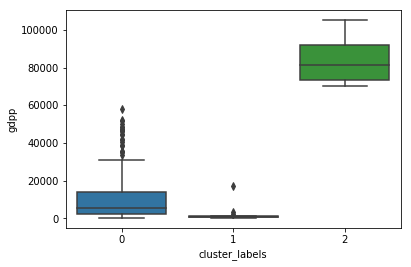

In [580]:
# plots
sns.boxplot(x='cluster_labels', y='gdpp', data=df)

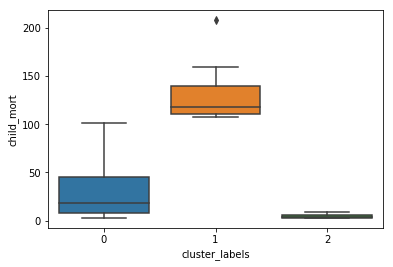

In [581]:
# plots
sns.boxplot(x='cluster_labels', y='child_mort', data=df)

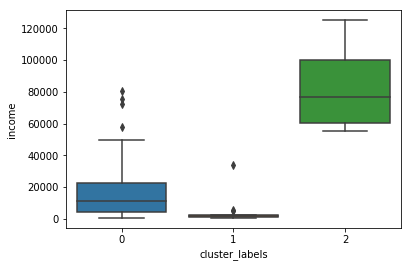

In [582]:
# plots
sns.boxplot(x='cluster_labels', y='income', data=df)

### Hierarchical Clustering conclusions.

From the above Data and visualizations we can conclude that below countries are in dire need of aid..

    # 1. Sierra Leone
    # 2. Central African Republic
    # 3. Haiti
    # 4. Mali
    # 5. Chad

# Overall considerations:



### K-means clustering:


Box plots and average cluster values for Chils_mort, income and GDPP reveal following pointers.

1. Cluster 0 has better GDPP and income compared to Cluster  1.
2. Cluster 0 has lower Child mort compared to Cluster  1.
3. Above box plot visualizations depict the same behaiour.

From the above facts we can conclude that cluster - 1 is worst performing and can extract countries performing less than mean values of corresponding mean values for **GDPP = "10324.175", Child-mort = 48.43 and income = 14978.95**.

So finally we have below list of countries having "GDPP","Child-mort","income" values less than above mean values, which are in dire need of aid.

    # 1. Burundi
    # 2. Liberia
    # 3. Congo, Dem. Rep.
    # 4. Niger
    # 5. Sierra Leone


### Hierarchical clustering:


Box plots and average cluster values for Chils_mort, income and GDPP reveal following pointers.


1. Cluster 0 and 2 has better GDPP and income compared to Cluster  1.
2. Cluster 0 and 2 has lower Child mort compared to Cluster  1.

From the above facts we can conclude that cluster - 1 is worst performing and can extract countries performing less than mean values of corresponding mean values for **GDPP - "1988.25000", Child-mort 129.50000 and income 4047.562500**.

So finally we have below list of countries having "GDPP","Child-mort","income" values less than above mean values, which are in dire need of aid.


    # 1. Sierra Leone
    # 2. Central African Republic
    # 3. Haiti
    # 4. Mali
    # 5. Chad
    